In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
import math
from sklearn.metrics import mean_squared_error

[*********************100%%**********************]  1 of 1 completed


                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2017-03-26   974.015015  1007.960022   954.185974   966.724976   966.724976   
2017-04-02  1080.609985  1107.589966  1075.449951  1102.170044  1102.170044   
2017-04-09  1176.569946  1197.209961  1171.859985  1187.869995  1187.869995   
2017-04-16  1172.609985  1187.219971  1172.609985  1182.939941  1182.939941   
2017-04-23  1231.920044  1232.199951  1203.939941  1207.209961  1207.209961   

               Volume  
Date                   
2017-03-26  303668000  
2017-04-02  514187008  
2017-04-09  242343008  
2017-04-16  183231008  
2017-04-23  258951008  
Number of rows: 366


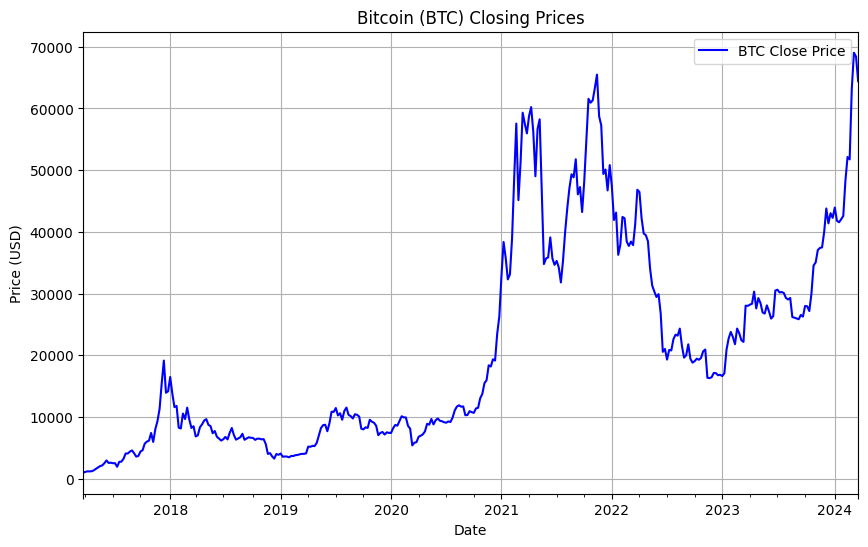

In [87]:
import yfinance as yf
import matplotlib.pyplot as plt

# Define the ticker symbol for Bitcoin (BTC)
ticker_symbol = 'BTC-USD'

# Fetch historical data for Bitcoin from Yahoo Finance
btc_data = yf.download(ticker_symbol, period='7y')  # Fetch data for the past year

# Take the weekly data
btc_data_weekly = btc_data.resample('W').last()

# Print the first few rows of the DataFrame
print(btc_data_weekly.head())

num_rows, num_cols = btc_data_weekly.shape
print("Number of rows:", num_rows)


# Plot the closing prices of Bitcoin
plt.figure(figsize=(10, 6))
btc_data_weekly['Close'].plot(label='BTC Close Price', color='blue')
plt.title('Bitcoin (BTC) Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [93]:
# Data Processing
scaler = MinMaxScaler()
btc_data_weekly = scaler.fit_transform(np.array(btc_data_weekly).reshape(-1,1))
btc_data_weekly.shape

(2196, 1)

In [71]:
# Split the Training and Testing Data
train_size = int(len(btc_data_weekly)*0.65)
test_size = len(btc_data_weekly) - train_size
train_data,test_data = btc_data_weekly[0:train_size,:],btc_data_weekly[train_size:len(btc_data_weekly),:1]

In [72]:
# New function created that splits based on time step
def create_dataset(dataset, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
                   a = dataset[i:(i+time_step),0]
                   dataX.append(a)
                   dataY.append(dataset[i + time_step,0])
    return np.array(dataX),np.array(dataY)

In [73]:
# calling the create dataset function to split the data into
# input output datasets with time step 100
time_step = 100
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)

In [74]:
# checking values
print(X_train.shape)
print(X_train)
print(X_test.shape)
print(Y_test.shape)

(1326, 100)
[[2.03439726e-10 5.51704835e-10 0.00000000e+00 ... 1.13326852e-08
  9.11926073e-09 1.00096980e-08]
 [5.51704835e-10 0.00000000e+00 1.28646215e-10 ... 9.11926073e-09
  1.00096980e-08 1.00096980e-08]
 [0.00000000e+00 1.28646215e-10 1.28646215e-10 ... 1.00096980e-08
  1.00096980e-08 1.21358649e-02]
 ...
 [3.91342104e-07 3.91342104e-07 4.17252310e-01 ... 4.84726726e-07
  2.73298689e-01 5.54009022e-07]
 [3.91342104e-07 4.17252310e-01 3.55077001e-07 ... 2.73298689e-01
  5.54009022e-07 5.68870017e-07]
 [4.17252310e-01 3.55077001e-07 3.60169332e-07 ... 5.54009022e-07
  5.68870017e-07 5.46944587e-07]]
(668, 100)
(668,)


In [75]:
# Creating and Fitting LSTM Model
input_shape = (X_train.shape[1], 1)

# Creating and Fitting LSTM Model
model = Sequential()
model.add(Input(shape=input_shape))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [76]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 100,batch_size = 64,verbose = 1)


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 290ms/step - loss: 0.0124 - val_loss: 0.0062
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - loss: 0.0130 - val_loss: 0.0062
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - loss: 0.0097 - val_loss: 0.0065
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step - loss: 0.0140 - val_loss: 0.0061
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - loss: 0.0105 - val_loss: 0.0060
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - loss: 0.0139 - val_loss: 0.0059
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - loss: 0.0105 - val_loss: 0.0054
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - loss: 0.0106 - val_loss: 0.0041
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 305ms/step - loss: 0.0085 - val_loss: 0.0037
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 295ms/step - loss: 0.0083 - val_loss: 0.0037
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 264ms/step - loss: 0.0063 - val_loss: 0.0036
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━

In [78]:
# Predictions and checking model performance

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


In [79]:
# Convert back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [80]:
# Calculate the rmse performance matrix

print(math.sqrt(mean_squared_error(Y_train,train_predict)))
print(math.sqrt(mean_squared_error(Y_test,test_predict)))

11842777842.033401
9272574936.272846


# Graph Plotting

In [81]:
look_back = 100
trainPredictPlot = np.empty_like(btc_data_weekly)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

In [82]:
testPredictPlot = np.empty_like(btc_data_weekly)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2 + 1 : len(btc_data_weekly) - 1,:] = test_predict

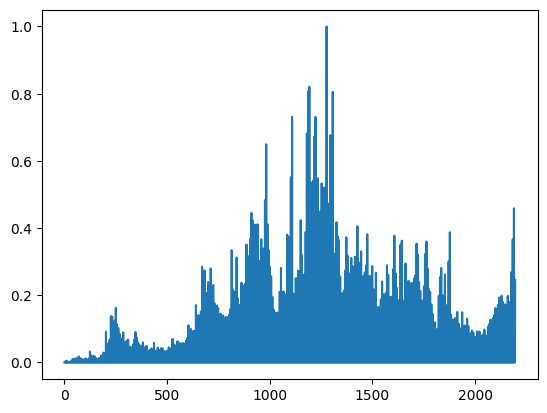

In [94]:
plt.plot(btc_data_weekly, label='Original Data')

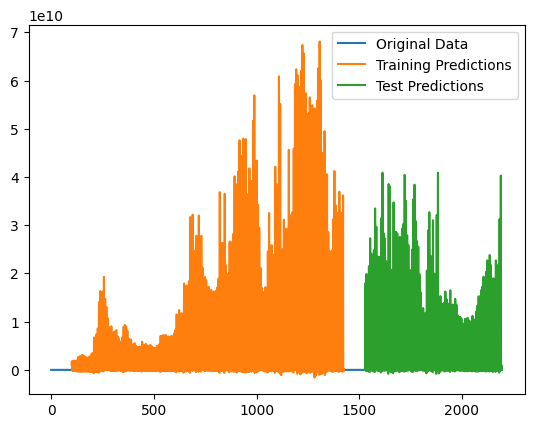

In [84]:

plt.plot(btc_data_weekly, label='Original Data')
plt.plot(trainPredictPlot, label='Training Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.legend()
plt.show()

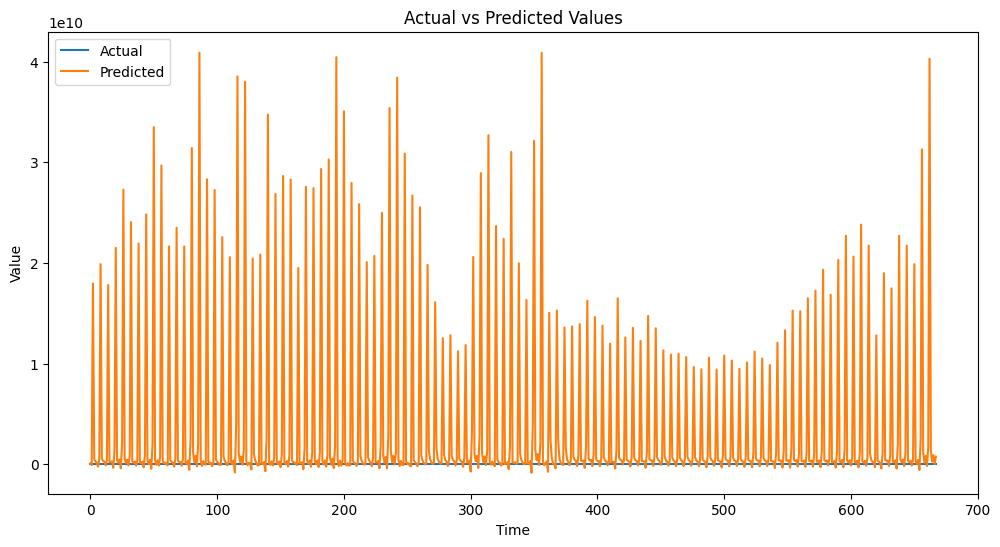

In [85]:
# Model Evaluations
import matplotlib.pyplot as plt

# Plotting the predicted values against the actual values
plt.figure(figsize=(12, 6))
plt.plot(Y_test, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()



ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None